In [1]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 9.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [4]:
df = pd.read_csv('hsp90_03_data_label.csv')

## Menghitung Lipinski Deskriptor

In [5]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [7]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,343.362,2.6672,1.0,7.0
1,303.297,1.6822,2.0,6.0
2,433.871,3.2310,1.0,8.0
3,369.400,2.5690,1.0,7.0
4,364.781,2.6916,2.0,6.0
...,...,...,...,...
1116,733.678,7.8788,4.0,9.0
1117,717.223,7.3645,4.0,9.0
1118,386.612,4.4140,0.0,4.0
1119,554.677,3.9003,3.0,9.0


## Menggabungkan antara dataset dengan deskriptor lipinski

In [8]:
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL109822,CCCCn1c(Cc2ccc3c(c2)OCO3)nc2c(N)nc(F)nc21,17100.0,inactive,343.362,2.6672,1.0,7.0
1,CHEMBL324951,COc1ccc(OC)c(Cc2nc3nc(F)nc(N)c3[nH]2)c1,53500.0,inactive,303.297,1.6822,2.0,6.0
2,CHEMBL112953,C#CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2Cl)nc2c(N)nc(F)...,30000.0,inactive,433.871,3.2310,1.0,8.0
3,CHEMBL326082,C#CCCCn1c(Cc2cc(OC)ccc2OC)nc2c(N)nc(F)nc21,4100.0,intermediate,369.400,2.5690,1.0,7.0
4,CHEMBL414883,C[C@@H]1C[C@H]2O[C@@H]2/C=C\C=C\C(=O)Cc2c(Cl)c...,200.0,active,364.781,2.6916,2.0,6.0
...,...,...,...,...,...,...,...,...
1116,CHEMBL5406770,CC(C)c1cc(C(=O)N2CCc3c(sc4nc(-c5ccc(NC(=O)Nc6c...,365.0,active,733.678,7.8788,4.0,9.0
1117,CHEMBL5396806,CC(C)c1cc(C(=O)N2CCc3c(sc4nc(-c5ccc(NC(=O)Nc6c...,69.0,active,717.223,7.3645,4.0,9.0
1118,CHEMBL5414509,CN1CCN(/C=C/C(=O)/C=C/c2cccc(O[Si](C)(C)C(C)(C...,187.0,active,386.612,4.4140,0.0,4.0
1119,CHEMBL5398773,CCCC[C@@H]1C[C@@H]2C(C(=O)OCC(C)C)=C(O)[C@H](C...,45800.0,inactive,554.677,3.9003,3.0,9.0


<Axes: >

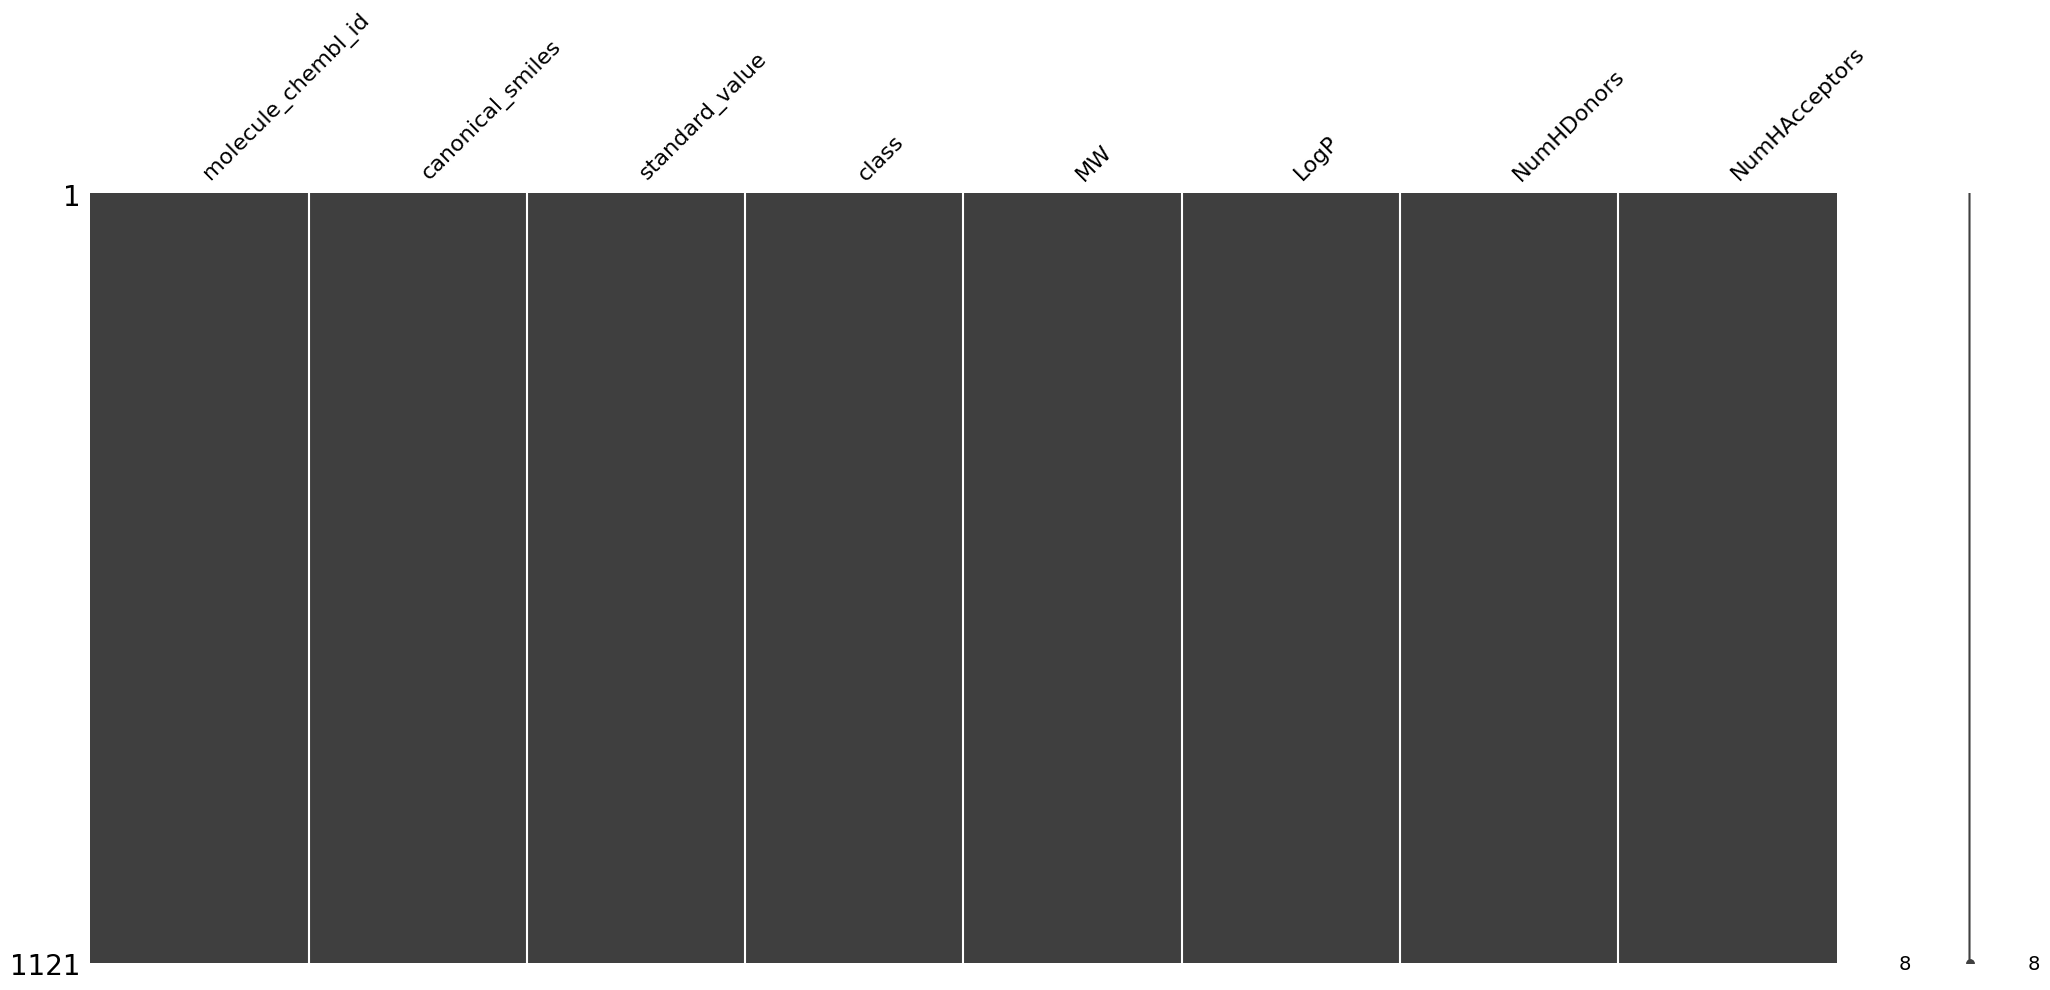

In [9]:
import missingno as msno

msno.matrix(df_combined)

## Convert IC50 to pIC50

In [18]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)

    return x

In [19]:
df_combined.standard_value.describe()

,standard_value
count,1.121000e+03
mean,3.898486e+04
std,2.653584e+05
min,6.000000e+00
25%,2.100000e+02
50%,2.900000e+03
75%,3.500000e+04
max,7.000000e+06


In [20]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1)

    return x

In [21]:
df_norm = norm_value(df_combined)
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL109822,CCCCn1c(Cc2ccc3c(c2)OCO3)nc2c(N)nc(F)nc21,inactive,343.362,2.6672,1.0,7.0,4.767004
1,CHEMBL324951,COc1ccc(OC)c(Cc2nc3nc(F)nc(N)c3[nH]2)c1,inactive,303.297,1.6822,2.0,6.0,4.271646
2,CHEMBL112953,C#CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2Cl)nc2c(N)nc(F)...,inactive,433.871,3.2310,1.0,8.0,4.522879
3,CHEMBL326082,C#CCCCn1c(Cc2cc(OC)ccc2OC)nc2c(N)nc(F)nc21,intermediate,369.400,2.5690,1.0,7.0,5.387216
4,CHEMBL414883,C[C@@H]1C[C@H]2O[C@@H]2/C=C\C=C\C(=O)Cc2c(Cl)c...,active,364.781,2.6916,2.0,6.0,6.698970
...,...,...,...,...,...,...,...,...
1116,CHEMBL5406770,CC(C)c1cc(C(=O)N2CCc3c(sc4nc(-c5ccc(NC(=O)Nc6c...,active,733.678,7.8788,4.0,9.0,6.437707
1117,CHEMBL5396806,CC(C)c1cc(C(=O)N2CCc3c(sc4nc(-c5ccc(NC(=O)Nc6c...,active,717.223,7.3645,4.0,9.0,7.161151
1118,CHEMBL5414509,CN1CCN(/C=C/C(=O)/C=C/c2cccc(O[Si](C)(C)C(C)(C...,active,386.612,4.4140,0.0,4.0,6.728158
1119,CHEMBL5398773,CCCC[C@@H]1C[C@@H]2C(C(=O)OCC(C)C)=C(O)[C@H](C...,inactive,554.677,3.9003,3.0,9.0,4.339135


In [22]:
df_final.pIC50.describe()

,pIC50
count,1121.000000
mean,5.619144
std,1.205012
min,2.154902
25%,4.455932
50%,5.537602
75%,6.677781
max,8.221849


In [23]:
df_final.to_csv('hsp90_04_3class_pIC50.csv')

## Menghapus kelas 'intermediet class'

In [24]:
df_final.rename(columns={'class': 'bioactivity_class'}, inplace=True)

In [25]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL109822,CCCCn1c(Cc2ccc3c(c2)OCO3)nc2c(N)nc(F)nc21,inactive,343.362,2.6672,1.0,7.0,4.767004
1,CHEMBL324951,COc1ccc(OC)c(Cc2nc3nc(F)nc(N)c3[nH]2)c1,inactive,303.297,1.6822,2.0,6.0,4.271646
2,CHEMBL112953,C#CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2Cl)nc2c(N)nc(F)...,inactive,433.871,3.2310,1.0,8.0,4.522879
4,CHEMBL414883,C[C@@H]1C[C@H]2O[C@@H]2/C=C\C=C\C(=O)Cc2c(Cl)c...,active,364.781,2.6916,2.0,6.0,6.698970
5,CHEMBL112896,CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2Cl)nc2c(N)ncnc21,inactive,405.886,3.4786,1.0,8.0,3.698970
...,...,...,...,...,...,...,...,...
1116,CHEMBL5406770,CC(C)c1cc(C(=O)N2CCc3c(sc4nc(-c5ccc(NC(=O)Nc6c...,active,733.678,7.8788,4.0,9.0,6.437707
1117,CHEMBL5396806,CC(C)c1cc(C(=O)N2CCc3c(sc4nc(-c5ccc(NC(=O)Nc6c...,active,717.223,7.3645,4.0,9.0,7.161151
1118,CHEMBL5414509,CN1CCN(/C=C/C(=O)/C=C/c2cccc(O[Si](C)(C)C(C)(C...,active,386.612,4.4140,0.0,4.0,6.728158
1119,CHEMBL5398773,CCCC[C@@H]1C[C@@H]2C(C(=O)OCC(C)C)=C(O)[C@H](C...,inactive,554.677,3.9003,3.0,9.0,4.339135


In [26]:
df_2class.isna().sum()

,0
molecule_chembl_id,0
canonical_smiles,0
bioactivity_class,0
MW,0
LogP,0
NumHDonors,0
NumHAcceptors,0
pIC50,0


In [27]:
df_2class.to_csv('hsp90_05_label2class_pIC50.csv', index=False)

# PLOTTING

## Plot frekuensi dari dua kelas bioaktifitas

In [34]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

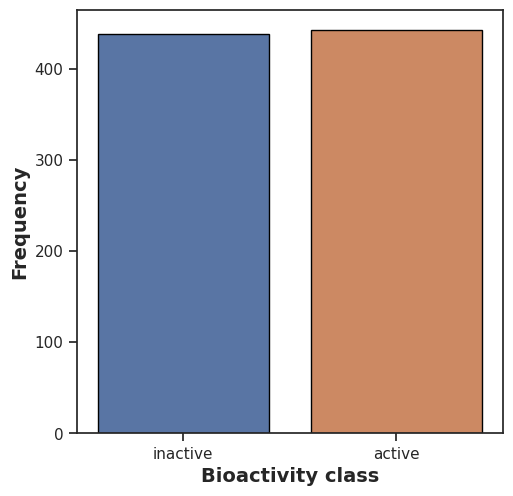

In [35]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, hue='bioactivity_class', edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

## Scatter plot of MW versus LogP

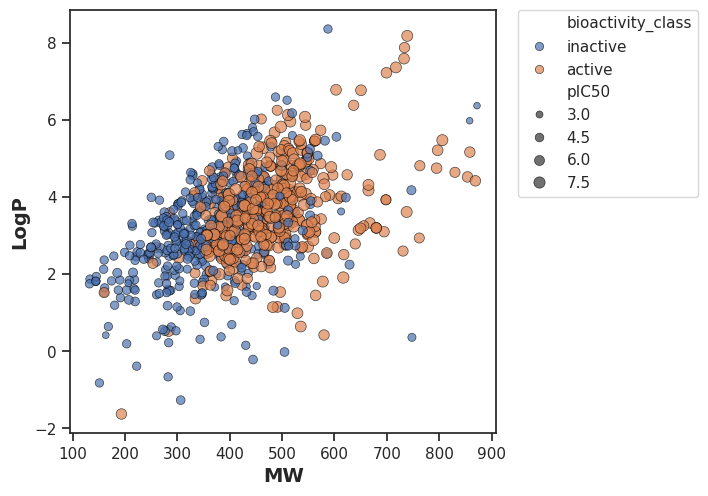

In [36]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

## pIC50 Value Boxplots

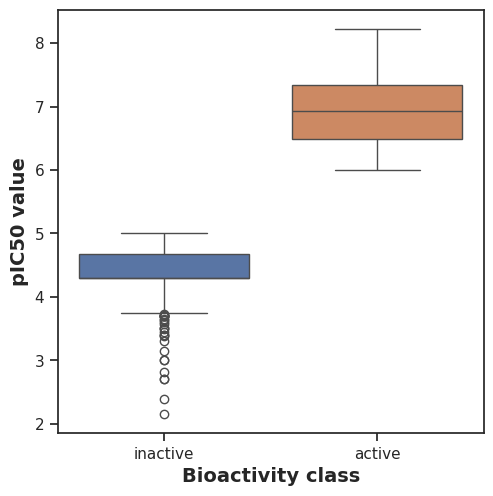

In [37]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', hue='bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

## Statistical analysis | Mann-Whitney U Test

In [38]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [39]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,194034.0,9.862513e-147,0.05,Different distribution (reject H0)


## MW

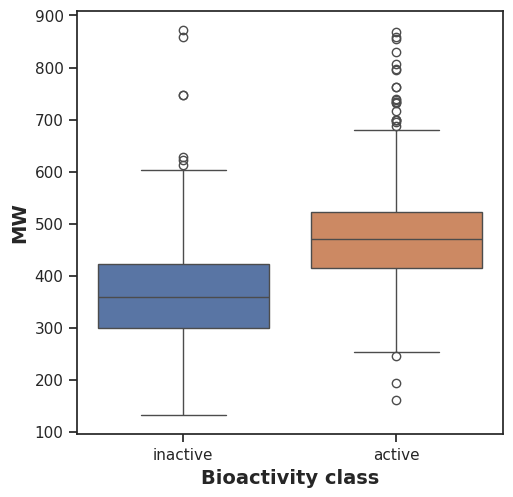

In [40]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', hue='bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [41]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,158001.0,1.165131e-58,0.05,Different distribution (reject H0)


## LogP

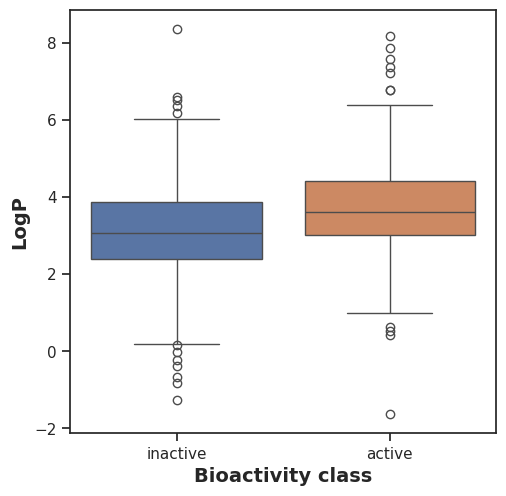

In [42]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', hue='bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [43]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,125802.5,2.492708e-14,0.05,Different distribution (reject H0)


## NumHDonors

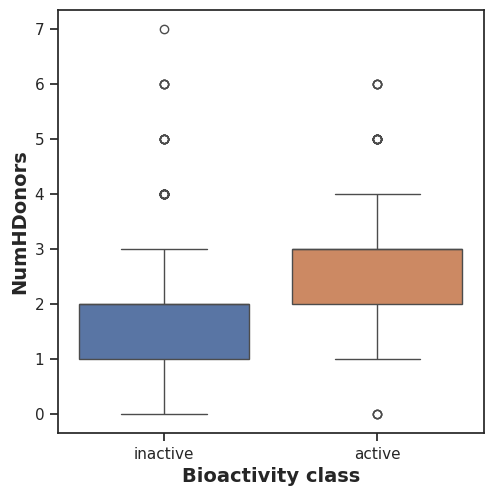

In [45]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', hue='bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [46]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,134774.5,4.388532e-25,0.05,Different distribution (reject H0)


## NumHAcceptors

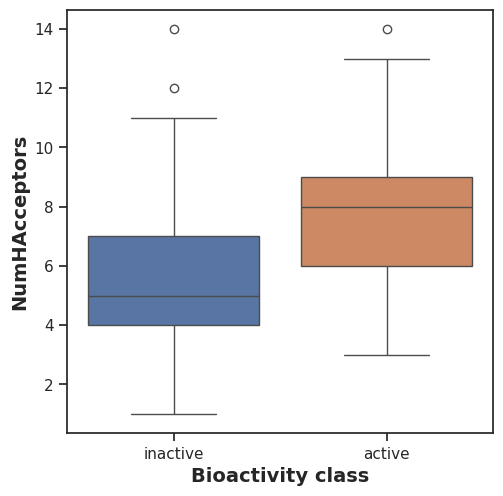

In [47]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', hue='bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [48]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,144560.5,6.392865e-37,0.05,Different distribution (reject H0)


In [49]:
! zip -r results.zip . -i *.csv *.pdf

  adding: plot_ic50.pdf (deflated 36%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: plot_LogP.pdf (deflated 38%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 9%)
  adding: plot_MW.pdf (deflated 37%)
  adding: hsp90_03_data_label.csv (deflated 81%)
  adding: plot_NumHAcceptors.pdf (deflated 36%)
  adding: hsp90_05_label2class_pIC50.csv (deflated 77%)
  adding: mannwhitneyu_LogP.csv (deflated 9%)
  adding: mannwhitneyu_MW.csv (deflated 8%)
  adding: plot_NumHDonors.pdf (deflated 38%)
  adding: hsp90_04_3class_pIC50.csv (deflated 76%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 10%)
  adding: plot_MW_vs_LogP.pdf (deflated 4%)
  adding: plot_bioactivity_class.pdf (deflated 38%)
